# TP 1 et 2: Linear Discriminant Analysis (LDA)


Enseignants: S. Zhang (2022), J. Chirinos-Rodriguez (2025) (jonathaneduardo.chirinosrodriguez@toulouse-inp.fr)

Etudiante: Ines Besbes

Ce TP couvre **2 séances**. Le but est de classifier des simulations du milieu interstellaire. Nous allons réaliser des analyses discriminantes linéaires (LDA) en utilisant différents estimateurs statistiques :
1. la moyenne empirique
2. la matrice d'autocovariance empirique
3. le spectre de puissance

On comparera ensuite les performances de ces différentes méthodes.

On pourra se référer à cette page Wikipédia sur la LDA: https://fr.wikipedia.org/wiki/Analyse_discriminante_lin%C3%A9aire

**Evaluation :**
Ce notebook sera évalué. Il comptera pour 15% de la note finale. Le notebook devra être rendu avant le **06 Juin 2025**.

Critères d'évaluation : 
- code qui tourne (sans retourner d'erreur) et est-ce que le code répond à la question.
- clareté : commentaires, docstrings pour les fonctions, axes, titre et légende sur les plots...
- effort de recherche et mise en application des concepts du cours.

**Acknowledgements: L. Mousset (2023), P. Richard (2024)**

In [1]:
# For the plots
%matplotlib inline
import matplotlib.pyplot as plt

# Scientific calculation
import numpy as np
from scipy.fft import fft2, fftshift
import os
from kymatio.numpy import Scattering2D

# Home library in the folder with notebooks
from utils import bin_to_float, convert_cls2fls, save_obj, load_obj

# Scikit Learn package
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


## Charger les données

On va utiliser des cartes (256x256) pixels, ce sont des simulations du milieu interstellaire. Plusieurs jeux de simulations ont été réalisés en variant deux paramètres physiques : le champ magnétique et la température. En fonction des valeurs de ces deux paramètres, on a pu définir 9 classes. 

On lit les données qui sont stockées dans le dossier `data/`. Les cartes sont séparées en deux catégories:
- Train : les données d'apprentissage (= d'entrainement)
- Test : les données de validation réservées aux tests

Chaque catégorie est séparée en 9 classes. Pour la catégorie Train, chaque classe contient 20 images alors que pour la catégorie Test, chaque classe contient 15 images.

Les images sont stockées en format binaire dans des fichiers `.dat`. Ces fichiers sont des tableaux 1D (256x256x8) où le 8 correspond aux 8 bytes.

In [2]:
# Parameters
NbClasses = 9
SizeMaps = 256
TrainBaseFolder = './data/LearnEchantillons'
NbMapsTrain = 20
TestBaseFolder = './data/ClassEchantillons'
NbMapsTest = 15

**0.1 TODO :** Ecrire une fonction qui charge les données. Elle doit retourner un dictionnaire de numpy arrays (#Images, 256, 256), chaque élément du dictionnaire correspondant à une classe. On pourra utiliser la fonction `np.fromfile()`.

In [3]:
def read_imgs(BaseFolder: str, NbClasses: int, NbMaps: int, SizeMaps: int) -> dict:
    """
    This function reads image data from files and organizes them into a dictionary by class.
    """
    imgs_cls = {}
    for i in range(1, NbClasses + 1):  # Iterate over each class
        imgs = np.zeros((NbMaps, SizeMaps, SizeMaps), dtype=np.float32)
        class_folder = os.path.join(BaseFolder, f'{i}')

        for j in range(1, NbMaps + 1):  # Iterate over each image in the class
            file_path = os.path.join(class_folder, f'{j}.dat')
            try:
                imgs[j - 1] = np.fromfile(file_path, dtype=np.float64).reshape((SizeMaps, SizeMaps))
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

        imgs_cls[i] = imgs  # Store the images of the class in the dictionary

    return imgs_cls

**0.2 TODO :** En appliquant la fonction `read_imgs()`, contruire 2 dictionnaires avec les données Test et les données Train

In [4]:
ImgsTrain = read_imgs(TrainBaseFolder, NbClasses, NbMapsTrain, SizeMaps)
ImgsTest = read_imgs(TestBaseFolder, NbClasses, NbMapsTest, SizeMaps)

**0.3 TODO :**  Sauver chaque dictionnaire sous la forme d'un fichier pickles. On utilisera la fonction `save_obj()` de `utils.py()`.

In [5]:
save_obj(ImgsTrain, "ImgsTrain")
save_obj(ImgsTest, "ImgsTest")

Remarque: Ces fichiers peuvent être chargés avec la fonction `load_obj`. Cela sera utile pour les prochains TPs.

In [6]:
ImgsTrain = load_obj('ImgsTrain')
ImgsTest = load_obj('ImgsTest')

**0.4 TODO :** Afficher des images de différentes classes. Peut-on différencier les classes à l'oeil nu ?

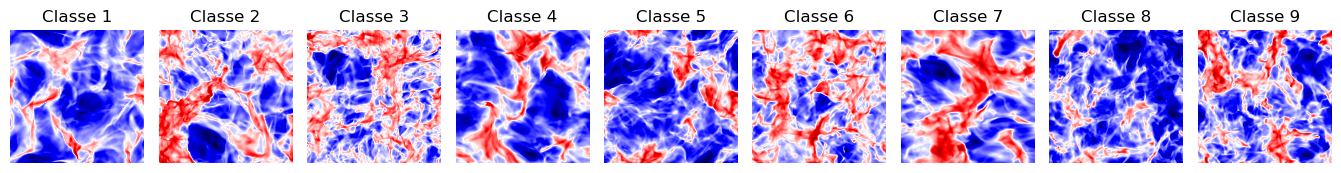

In [7]:
plt.figure(figsize=(15, 5))
for i in range(1,NbClasses+1):
    plt.subplot(1, NbClasses+1, i + 1)
    plt.imshow(ImgsTrain[i][1], cmap='seismic') 
    plt.title(f"Classe {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**0.5 TODO :** Quelles conditions aux limites vérifient ces images ? On pourra faire un plot d'une image en utilisant la fonction `np.roll()` (https://stackoverflow.com/questions/19878280/efficient-way-to-shift-2d-matrices-in-both-directions).

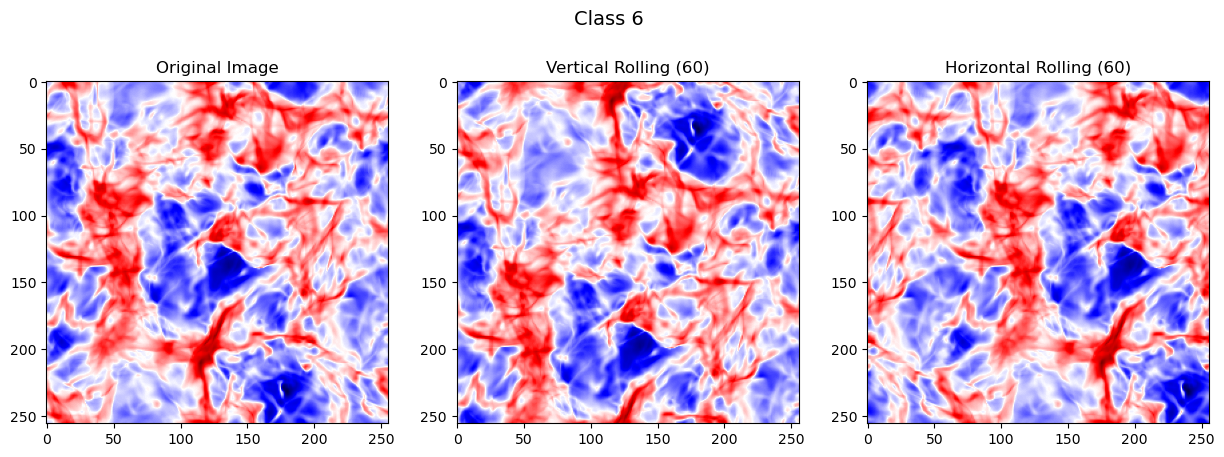

In [8]:
def display_rolled_images(ImgsTrain: dict, num_class: int, shift: int = 60):
    """
    This function displays an original image and its vertically and horizontally rolled versions.
    Rolling is performed using numpy's roll function with a specified shift value.
    """
    img = ImgsTrain[num_class][1]  # first image of the class
    img_v = np.roll(img, shift, axis=0)  # vertical rolling
    img_h = np.roll(img, shift, axis=1)  # horizontal rolling

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Class {num_class}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap='seismic')

    plt.subplot(1, 3, 2)
    plt.title(f"Vertical Rolling ({shift})")
    plt.imshow(img_v, cmap='seismic')

    plt.subplot(1, 3, 3)
    plt.title(f"Horizontal Rolling ({shift})")
    plt.imshow(img_h, cmap='seismic')

    plt.show()


display_rolled_images(ImgsTrain, 6)

## Etape 1: Linear Discriminant Analysis (LDA) avec la moyenne empirique

**1.1 TODO :** Compléter la fonction suivante qui doit retourner un dictionnaire contenant la moyenne de chaque image.

In [9]:
def compute_features_mean(Imgs: dict, NbClasses: int, NbMaps: int) -> dict:
    """
    This function calculates the mean value of each image in a given dictionary of images,
    organized by class. The result is a dictionary where each key is a class identifier,
    and the corresponding value is an array of mean values for each image in that class.
    """
    mu_cls = {}
    for c in range(1, NbClasses + 1):
        mu_cls[c] = np.array([np.mean(Imgs[c][i]) for i in range(NbMaps)])
    return mu_cls

**1.2 TODO :** Appliquer la fonction précédente pour construire deux dictionnaires associés aux cartes Train et Test. Afficher les valeurs des moyennes et les tracer sur un graphe. A votre avis, la moyenne est-elle un bon marqueur statistique pour classifier ces images ?

In [10]:
MeanTrain = compute_features_mean(ImgsTrain, NbClasses, NbMapsTrain)
MeanTest = compute_features_mean(ImgsTest, NbClasses, NbMapsTest)

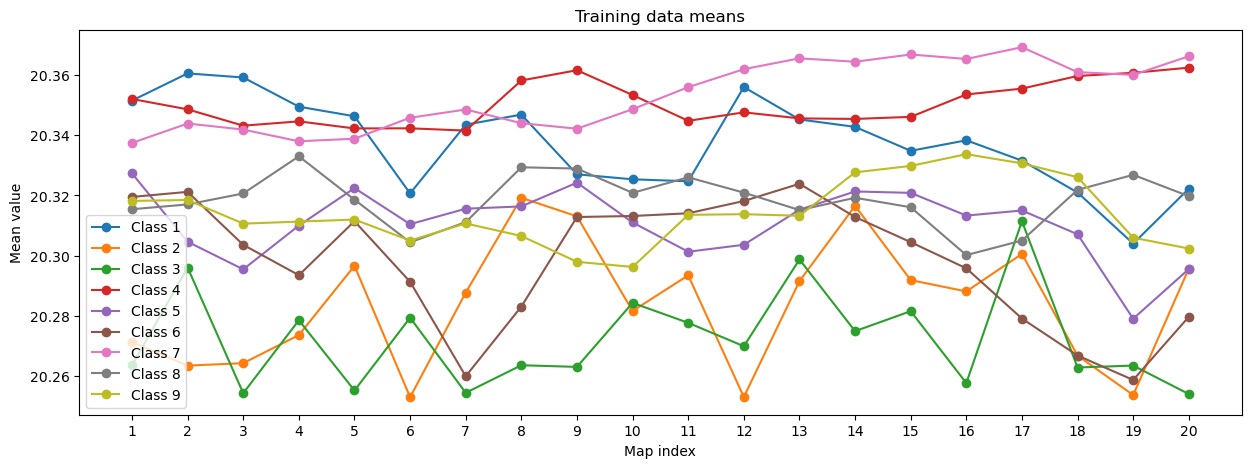

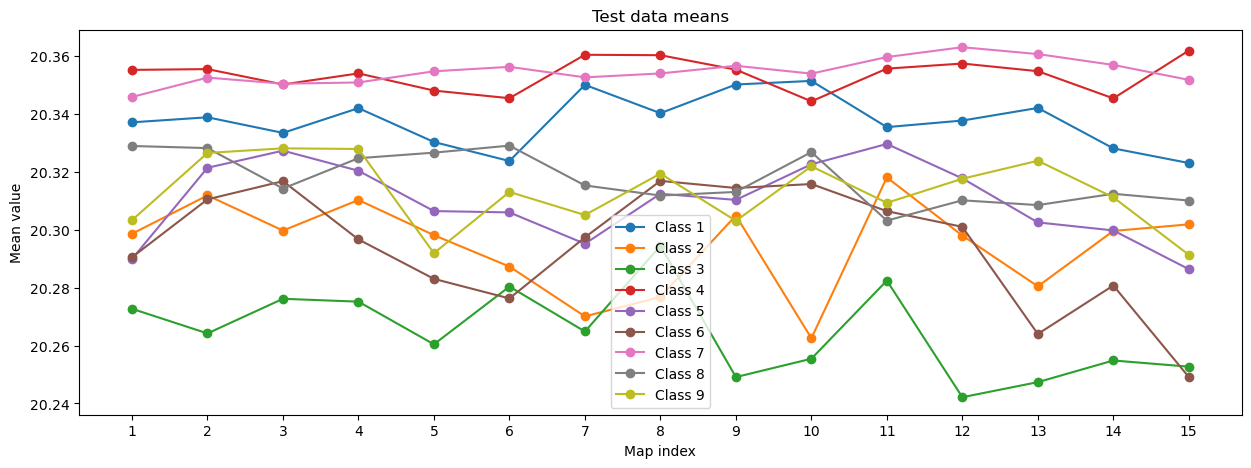

In [11]:
plt.figure(figsize=(15, 5))
for i in range(1, NbClasses + 1):
    means_train = MeanTrain[i][0:]
    plt.plot(range(1, NbMapsTrain + 1), means_train, marker='o', label=f'Class {i}')
plt.xticks(np.arange(1, NbMapsTrain + 1, 1))
plt.title("Training data means")
plt.xlabel("Map index")
plt.ylabel("Mean value")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
for i in range(1, NbClasses + 1):
    means_test = MeanTest[i][0:]
    plt.plot(range(1, NbMapsTest + 1), means_test, marker='o', label=f'Class {i}')
plt.xticks(np.arange(1, NbMapsTest + 1, 1))
plt.title("Test data means")
plt.xlabel("Map index")
plt.ylabel("Mean value")
plt.legend()
plt.show()

**1.3 TODO :** Compléter la fonction suivante qui réalise la classification par LDA. **Cette fonction sera réutilisée dans les TP suivants.** En plus de la LDA, elle devra retourner les matrices de confusion et les test d'accuracy sur les données Train et Test. 

Nous allons utiliser la librairie scikit-learn. Voir éventuellement : https://scikit-learn.org/0.24/auto_examples/classification/plot_lda_qda.html?highlight=lda

Ne pas hésiter à prendre des fonctions toutes faites pour le calcul de confusion et d'accuracy.

In [12]:
def classify_by_LDA(dataTrain: dict, dataTest: dict) -> dict:
    """
    This function performs classification using Linear Discriminant Analysis (LDA).
    It converts the input data into features and labels, fits an LDA classifier,
    and evaluates the classifier's performance on both training and test data.
    The performance metrics include confusion matrices and accuracy scores.
    """
    # Build features and labels
    featuresTrain, labelsTrain = convert_cls2fls(dataTrain, NbClasses, NbMapsTrain)
    featuresTest, labelsTest = convert_cls2fls(dataTest, NbClasses, NbMapsTest)

    # Initialize and fit the LDA classifier
    clf = LinearDiscriminantAnalysis()
    clf.fit(featuresTrain, labelsTrain)

    # Predict and evaluate
    predsTrain = clf.predict(featuresTrain)
    predsTest = clf.predict(featuresTest)

    cmatTrain = confusion_matrix(labelsTrain, predsTrain)
    cmatTest = confusion_matrix(labelsTest, predsTest)

    accuracyTrain = accuracy_score(labelsTrain, predsTrain)
    accuracyTest = accuracy_score(labelsTest, predsTest)

    return {
        'train_cm': cmatTrain,
        'train_acc': accuracyTrain,
        'test_cm': cmatTest,
        'test_acc': accuracyTest,
        'lda': clf
    }


**1.4 TODO :** Appliquer la fonction `classify_by_LDA()` sur les moyennes et afficher les résultats (matrices de confusion et tests d'accuracy sur les données Train et Test). On pourra s'aider de https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

Train accuracy: 0.3333333333333333
Test accuracy: 0.37037037037037035


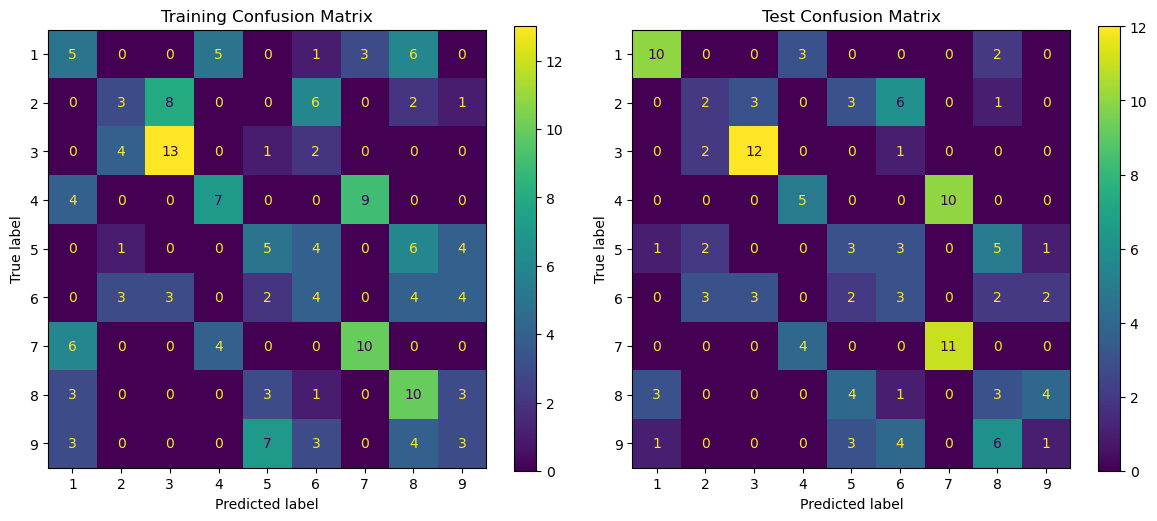

In [13]:
# Classify by LDA
resultsMean = classify_by_LDA(MeanTrain, MeanTest)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

display_labels = [i for i in range(1, 10)]  

# Display the results
ConfusionMatrixDisplay(resultsMean["train_cm"], display_labels=display_labels).plot(ax=axs[0])
axs[0].set_title("Training Confusion Matrix")
ConfusionMatrixDisplay(resultsMean["test_cm"], display_labels=display_labels).plot(ax=axs[1])
axs[1].set_title("Test Confusion Matrix")

print("Train accuracy:", resultsMean["train_acc"])
print("Test accuracy:", resultsMean["test_acc"])

plt.tight_layout()
plt.show()

1.5 TODO : Commenter le résultat. Naïvement, la moyenne d'échantillon vous semble t'elle être un bon marqueur pour ces données ?

## Etape 2 : LDA avec la matrice d'autocovariance

Autocovariance : https://fr.wikipedia.org/wiki/Autocovariance  
Autocorrélation : https://fr.wikipedia.org/wiki/Autocorr%C3%A9lation

Soit le vecteur translation $\tau = (\tau_1, \tau_2)$ avec $\tau_1 = 0, 1, ... dn$ et $\tau_2 = -dn, ..., -1, 0, 1, ... dn$. On note $X(u)$ la valeur de l'image $X$ en le pixel $u$. L'autocovariance du processus $X$ (supposé à valeurs réelles) est définie par:

$$\phi(u, \tau) = \mathbb{E} [(X(u)-\mu_u)(X(u-\tau)-\mu_{u-\tau})]$$

**2.1 TODO:** Qu'entend on par $\mathbb E$ dans une telle définition ? Que représentent $\mu_u$ et $\mu_{u-\tau}$ ? À quelle condition l'autocovariance ne dépend que de $\tau$ ? Jusitifer alors l'appelation "matrice d'autocovariance" dans notre cas et donner ses dimensions en fonction du choix de $dn$.

**2.2 TODO :** Proposer un estimateur de la matrice d'autocovariance calculé à partir d'une seule image. Ecrire une fonction qui calcule cet estimateur pour un $dn$ donné. La fonction retournera un dictionnaire de numpy arrays où chaque élément correspond à une classe.  

In [14]:
def compute_features_cov(Imgs: dict, dn: int, NbClasses: int, NbMaps: int) -> dict:
    """
    This function calculates the autocovariance matrices for images in each class based on
    specified displacement parameters. The autocovariance matrices are computed for each image
    by shifting the image and calculating the covariance of the differences from the mean.
    """
    covmat_cls = {}

    for i in range(1, NbClasses + 1): 
        imgs_cls = Imgs[i] 
        cov_list = []

        for img in imgs_cls:
            img = np.array(img, dtype=np.float32)
            mean_val = np.mean(img)
            cov_mat = np.zeros((dn + 1, 2 * dn + 1))

            for tau1 in range(dn + 1):
                for tau2 in range(-dn, dn + 1):
                    shifted_img = np.roll(img, shift=(-tau1, -tau2), axis=(0, 1)) # shift the image

                    diff = (img - mean_val) * (shifted_img - mean_val)
                    cov_mat[tau1, tau2 + dn] = np.mean(diff) # calculate the covariance


            cov_list.append(cov_mat.flatten())  # flatten for LDA

        covmat_cls[i] = cov_list

    return covmat_cls

**2.3 TODO :** Pour un $dn$ entre 0 et 8, calculer ces estimateurs de matrices de covariance sur les données Train et Test et réaliser une classification par LDA. Tracer les tests d'accuracy en fonction de $dn$. 

In [19]:
acc_train_list = []
acc_test_list = []

for dn in range(20):
    print(f"dn = {dn}")    
    covTrain = compute_features_cov(ImgsTrain, dn, NbClasses, NbMapsTrain)
    covTest = compute_features_cov(ImgsTest, dn, NbClasses, NbMapsTest)
    
    # Classify by LDA
    result = classify_by_LDA(covTrain, covTest)
    
    acc_train_list.append(result['train_acc'])
    acc_test_list.append(result['test_acc'])

dn = 0
dn = 1
dn = 2
dn = 3
dn = 4
dn = 5
dn = 6
dn = 7
dn = 8
dn = 9
dn = 10
dn = 11
dn = 12
dn = 13
dn = 14
dn = 15
dn = 16
dn = 17
dn = 18
dn = 19


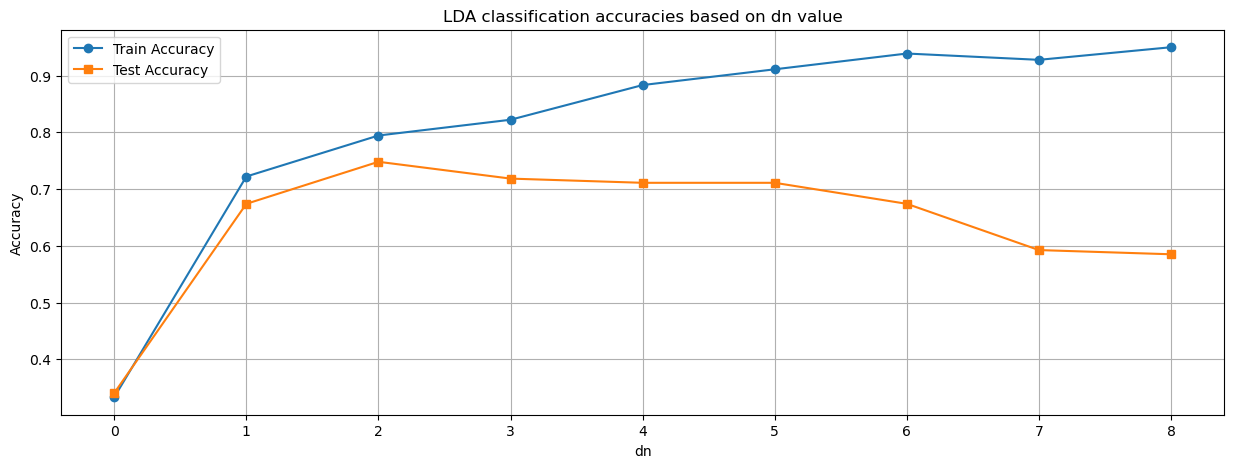

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(range(9), acc_train_list[:9], label="Train Accuracy", marker='o')
plt.plot(range(9), acc_test_list[:9], label="Test Accuracy", marker='s')
plt.xlabel("dn")
plt.ylabel("Accuracy")
plt.title("LDA classification accuracies based on dn value")
plt.legend()
plt.grid(True)
plt.show()

**2.4 TODO :** Commenter ces résultats et comparer brièvement à ceux obtenus à l'étape 1.

## Etape 3: LDA en utilisant le spectre de puissance (periodogram)

**3.1 TODO :** Rappeler le lien entre autocovariance et spectre de puissance.

**3.2 TODO :** Ecrire une fonction qui calcule le spectre de puissance de chaque image pour une fréquence maximale notée $dom$. Elle devra retourner un dictionnaire de numpy arrays, chaque élément du dictionnaire étant associé à une classe. On utilisera `fft2` de la librairie `scipy`. Caluler d'abord le spectre de puissance complet puis le tronquer à la fréquence maximale $dom$.

La fonction pourra plotter le spectre de puissance complet et tronqué pour une image en particulier.

In [15]:
def compute_features_ps(Imgs: dict, dom: int, NbClasses: int, NbMaps: int, SizeMaps: int, plot: bool) -> dict:
    """
    This function calculates the power spectrum for each image in the given dictionary of classes.
    It uses the Fast Fourier Transform (FFT) to compute the power spectrum and optionally plots
    the full and truncated power spectra for visualization. 
    """
    psmat_cls = {}

    if plot:
        fig, axs = plt.subplots(2, NbClasses, figsize=(20, 6))

    for i in range(1,NbClasses+1):
        psmat = np.zeros((NbMaps, 2 * dom + 1, 2 * dom + 1))
        for j in range(NbMaps):
            img = Imgs[i][j].astype(np.float32)

            fft_img = fft2(img) # compute FFT
            fft_img_shifted = fftshift(fft_img)  # center low frequencies
            ps_full = np.abs(fft_img_shifted) ** 2  # power spectrum

            H, W = ps_full.shape
            center_x, center_y = H // 2, W // 2   # truncate around the center
            ps_trunc = ps_full[center_x - dom:center_x + dom + 1,
                               center_y - dom:center_y + dom + 1]
            
            psmat[j] = ps_trunc # store the truncated spectrum

        if plot==True:
            axs[0, i-1].imshow(np.log1p(ps_full), cmap='seismic')
            axs[0, i-1].text(0.5, -0.1, f'Full spectrum {i}', size=10, ha='center', transform=axs[0, i-1].transAxes)  
            axs[0, i-1].axis('off')

            axs[1, i-1].imshow(np.log1p(ps_trunc), cmap='seismic')
            axs[1, i-1].text(0.5, -0.1, f'Truncated spectrum {i}', size=10, ha='center', transform=axs[1, i-1].transAxes)  
            axs[1, i-1].axis('off')

            fig.suptitle("Full spectrum vs truncated spectrum with dom=" +str(dom))

        psmat_cls[i] = psmat

    return psmat_cls

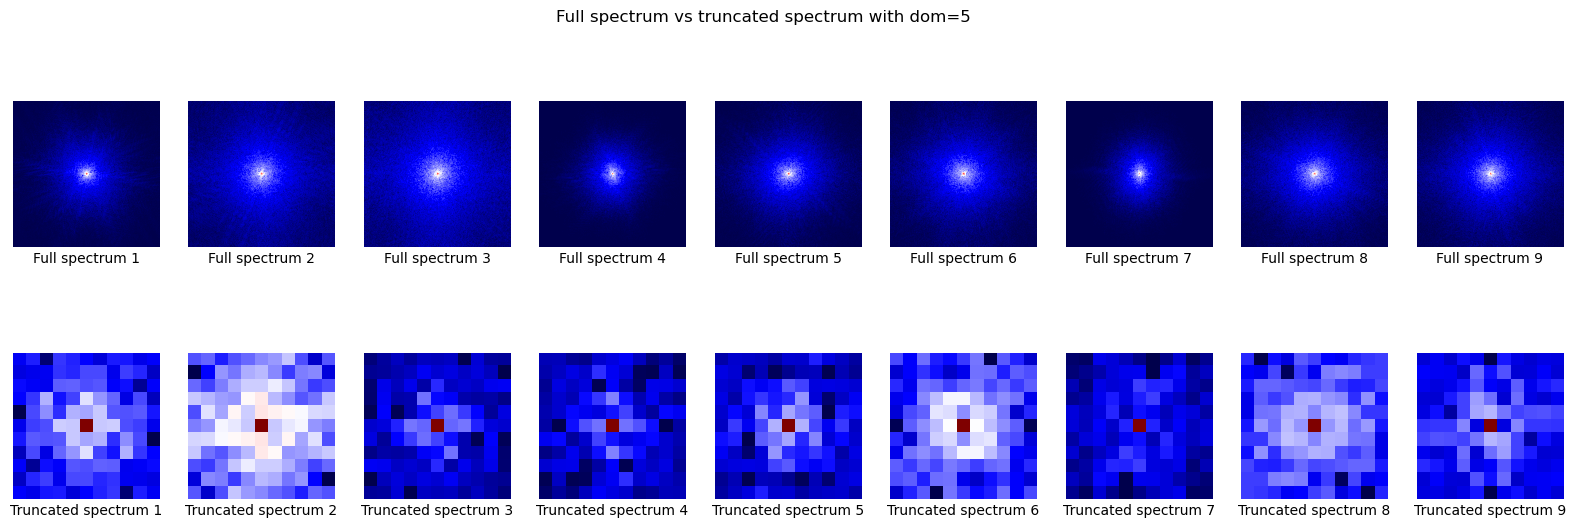

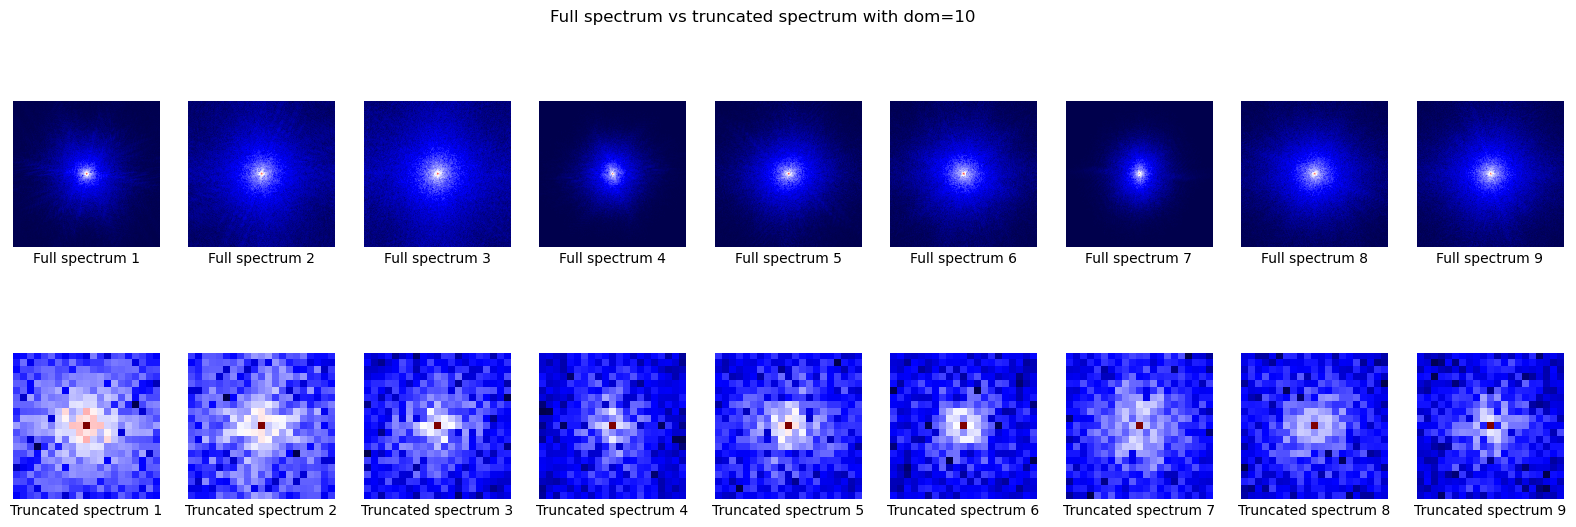

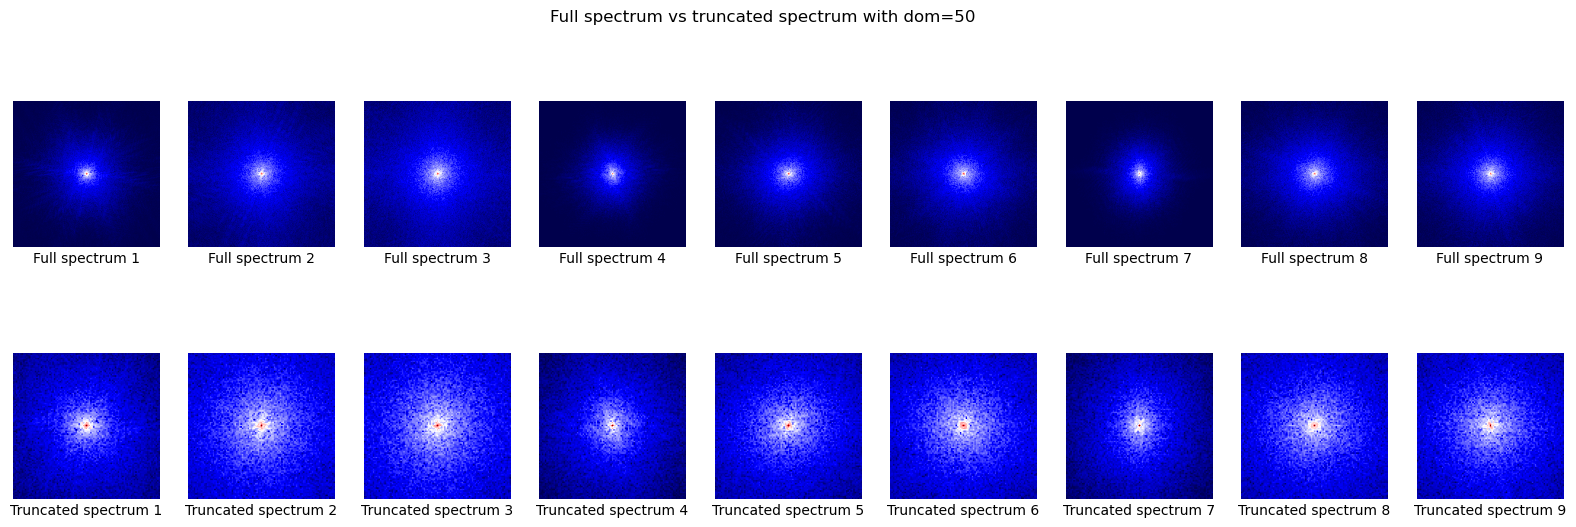

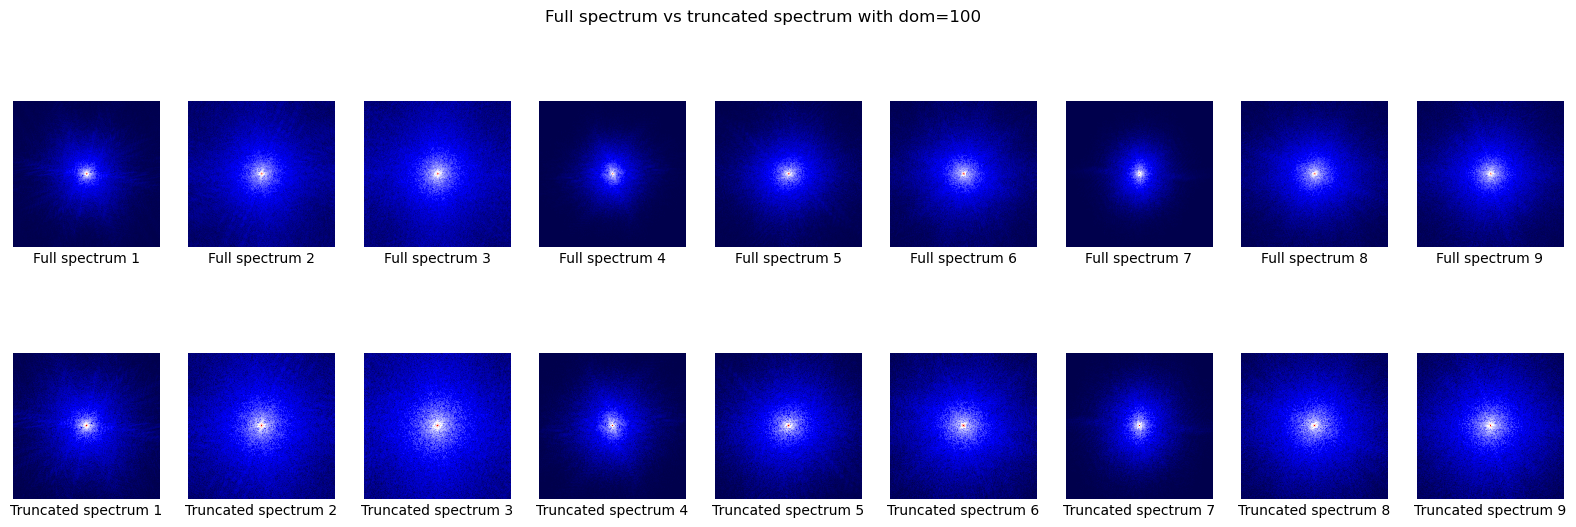

In [23]:
psmat_cls_5 = compute_features_ps(ImgsTrain, 5, NbClasses, NbMapsTrain, SizeMaps, True) # example with dom=5
psmat_cls_10 = compute_features_ps(ImgsTrain, 10, NbClasses, NbMapsTrain, SizeMaps, True) # example with dom=10
psmat_cls_50 = compute_features_ps(ImgsTrain, 50, NbClasses, NbMapsTrain, SizeMaps, True) # example with dom=10
psmat_cls_100 = compute_features_ps(ImgsTrain, 100, NbClasses, NbMapsTrain, SizeMaps, True) # example with dom=100

**3.3 TODO :** Quelle plage de valeurs du métaparamètre $dom$ proposez vous d'étudier et pourquoi ? Pour différents choix de $dom$ que vous proposerez, calculer les spectres de puissance sur les données Train et Test. Puis effectuer une classification par LDA. Tracer les tests d'accuracy en fonction de $dom$.

dom = 20
dom = 30
dom = 40
dom = 50
dom = 60
dom = 70
dom = 80
dom = 90


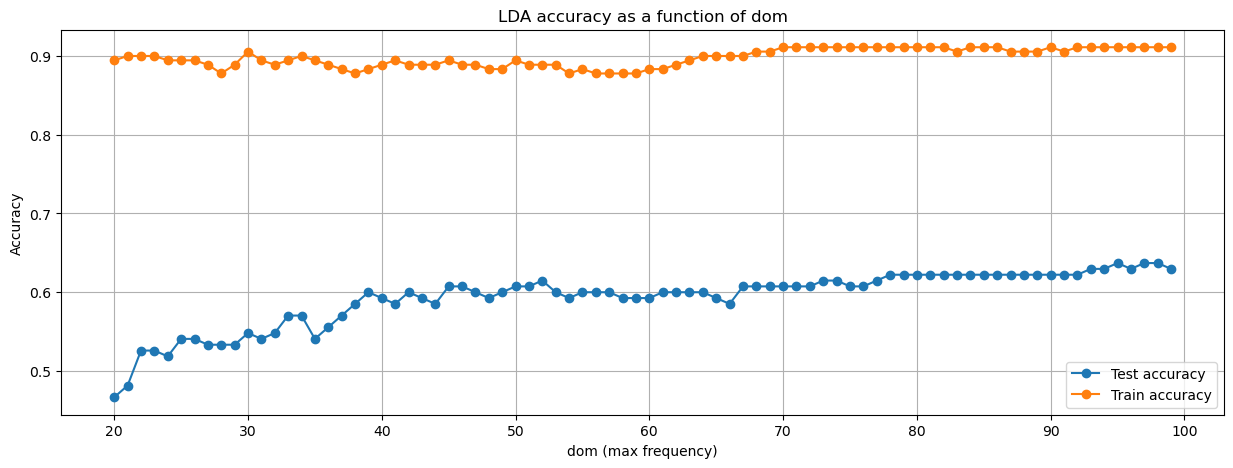

In [18]:
dom_range = list(range(20, 100))  

test_accuracies = []
train_accuracies = []

for dom in dom_range:
    psmat_train = compute_features_ps(ImgsTrain, dom, NbClasses, NbMapsTrain, SizeMaps, False)
    psmat_test = compute_features_ps(ImgsTest, dom, NbClasses, NbMapsTest, SizeMaps, False)

    result = classify_by_LDA(psmat_train, psmat_test)
    test_accuracies.append(result['test_acc'])
    train_accuracies.append(result['train_acc'])
    if dom % 10 == 0:
            print(f"dom = {dom}")

# Plot accuracy vs. dom
plt.figure(figsize=(15, 5))
plt.plot(dom_range, test_accuracies, marker='o', label='Test accuracy')
plt.plot(dom_range, train_accuracies, marker='o', label='Train accuracy')
plt.title("LDA accuracy as a function of dom")
plt.xlabel("dom (max frequency)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

**3.4 TODO :** Commenter ces résultats.

## Analyse des performances et conclusion 

Le but de cette section est de comparer les trois classifications LDA réalisées ci-dessus en terme de performances :
- Quelle méthode obtient les meilleurs résultats ?
- Quelle est celle qui a les plus grandes erreurs ?
- Comment l'erreur est-elle reliée à la variance des features choisis ?

Pour aider à répondre à ces questions, on définit la fonction plot suivante :

In [25]:
def plot_mean_per_class(results:dict, dataT: dict, NbMaps: int,  log_yscale: bool):
    ''' 
    This function generates two types of plots for each class:
    1. Individual plots showing the features of each sample in the class and the mean feature vector.
    2. A combined plot showing the mean feature vector with error bars representing the standard deviation.
    '''
    fig = plt.figure(figsize=(15,10))
    fig.suptitle("Class feature vectors")  
    ymax = max(list(map(np.max, dataT.values())))
    ymin = min(list(map(np.min, dataT.values())))
    for i in range(1,NbClasses+1):            
        plt.subplot(3, 3, i)
        for j in range(NbMaps):
            features = dataT[i][j].reshape(-1)
            # print(features)
            plt.plot(features, color='b', alpha=.3)

        plt.plot(results['lda'].means_[i-1], color='r')
        plt.title(f'Class {i}')
        plt.ylim([ymin, ymax])
        plt.yscale('log') if log_yscale else None
    plt.show()

    fig = plt.figure(figsize=(15,5))
    fig.suptitle("Mean features with error bars")  
    for i in range(1,NbClasses+1):         
        errors = np.std(np.array(dataT[i]),axis=0).reshape(-1)
        plt.errorbar(x=range(len(results['lda'].means_[i-1])), y=results['lda'].means_[i-1], yerr=errors, label='class {:}'.format(i))

    plt.ylim([ymin, ymax])
    plt.yscale('log') if log_yscale else None

    plt.legend()
    plt.show()
        
    return

**4.1 TODO :** Conclure sur les performances de la LDA sur ces trois choix de features.

In [42]:
# Results with empirical mean
MeanTrain = compute_features_mean(ImgsTrain, NbClasses, NbMapsTrain)
MeanTest = compute_features_mean(ImgsTest, NbClasses, NbMapsTest)
resultsMean = classify_by_LDA(MeanTrain, MeanTest)

# Results with empirical autocovariance
dn_opt = 3
covTrain = compute_features_cov(ImgsTrain, dn_opt, NbClasses, NbMapsTrain)
covTest = compute_features_cov(ImgsTest, dn_opt, NbClasses, NbMapsTest)
resultsAutoCov = classify_by_LDA(covTrain, covTest)

# Results with power spectrum
dom_opt = 80
ps_train = compute_features_ps(ImgsTrain, dom_opt, NbClasses, NbMapsTrain, SizeMaps, False)
ps_test  = compute_features_ps(ImgsTest, dom_opt, NbClasses, NbMapsTest, SizeMaps, False)
resultsPS = classify_by_LDA(ps_train, ps_test)

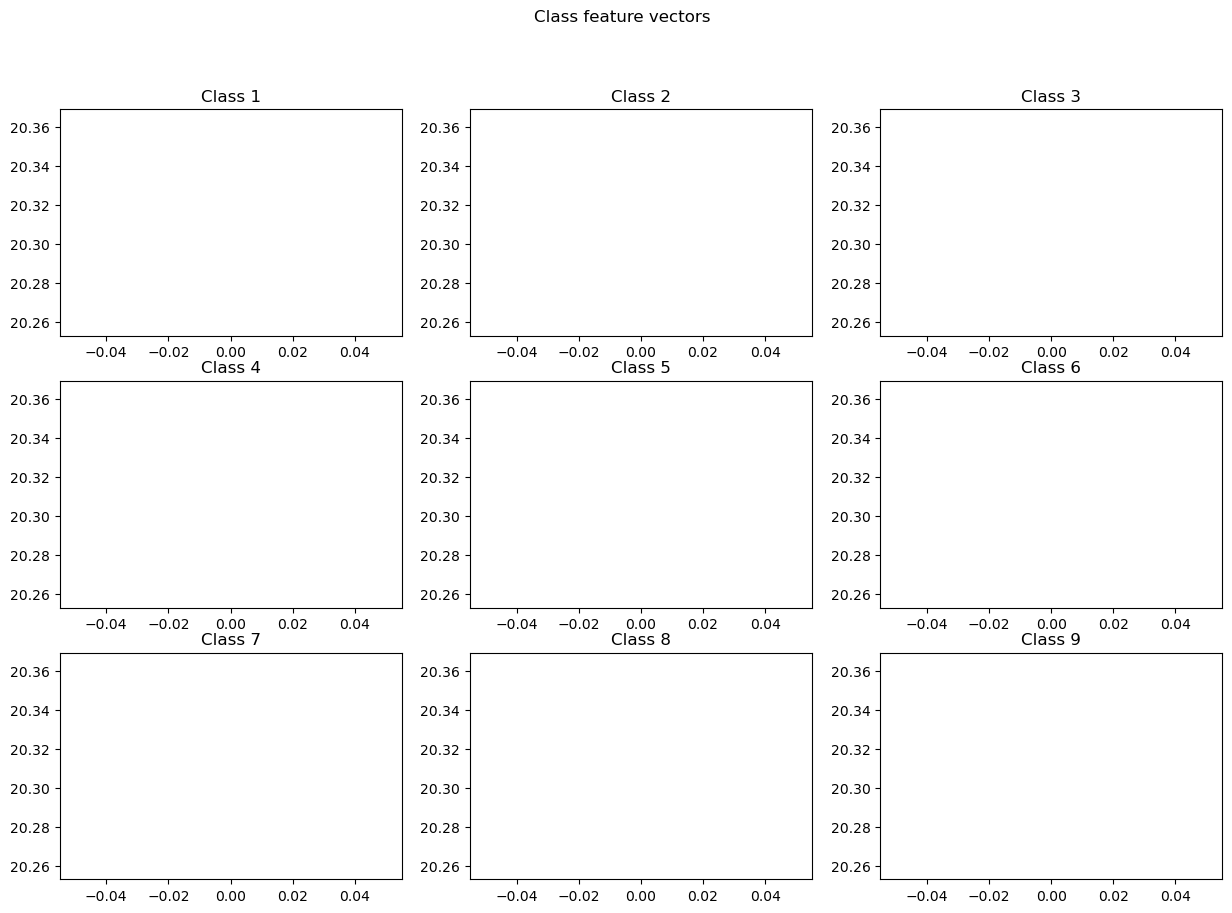

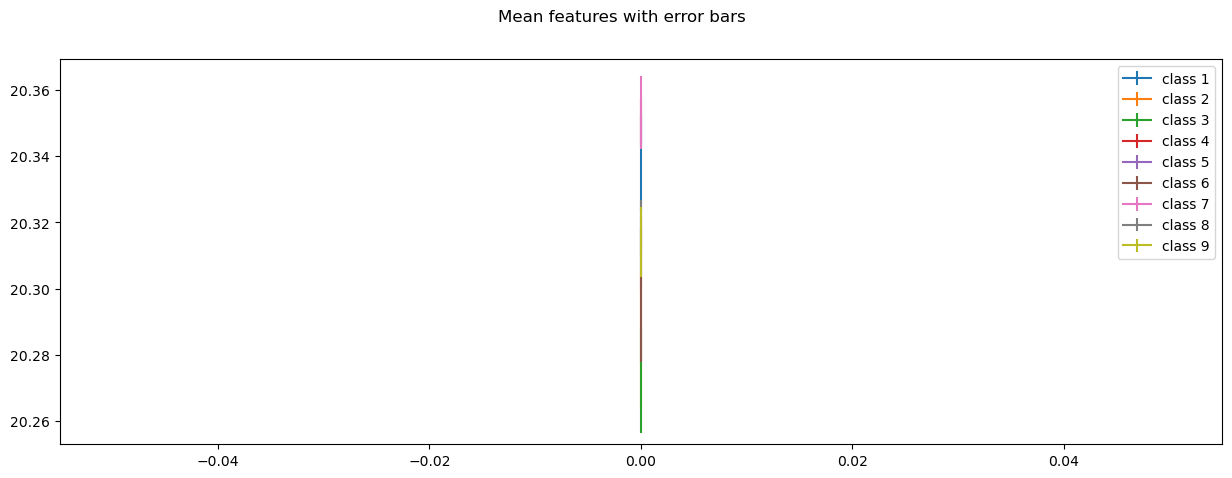

In [36]:
plot_mean_per_class(resultsMean, MeanTrain, NbMapsTrain, False)
# plot_mean_per_class(resultsMean, MeanTest, NbMapsTest, False)

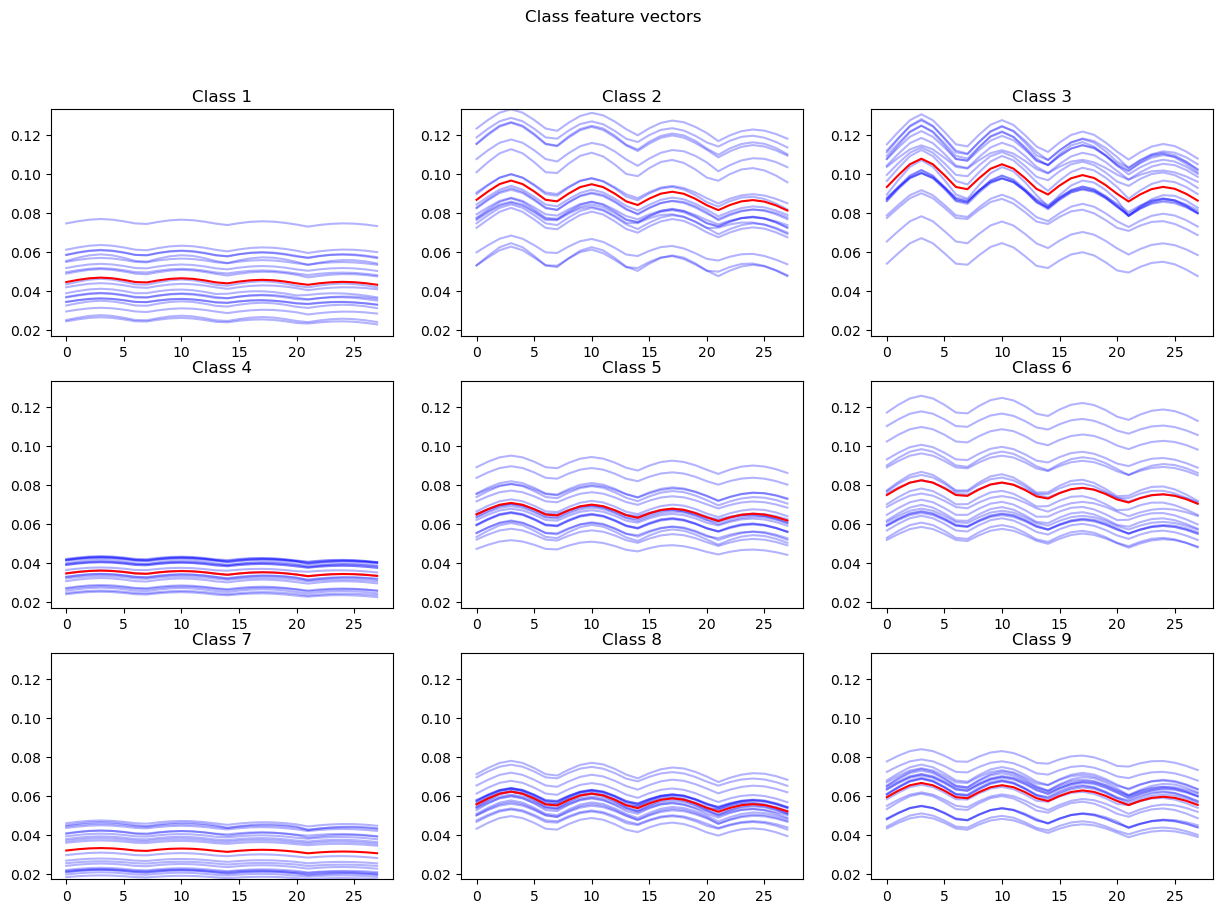

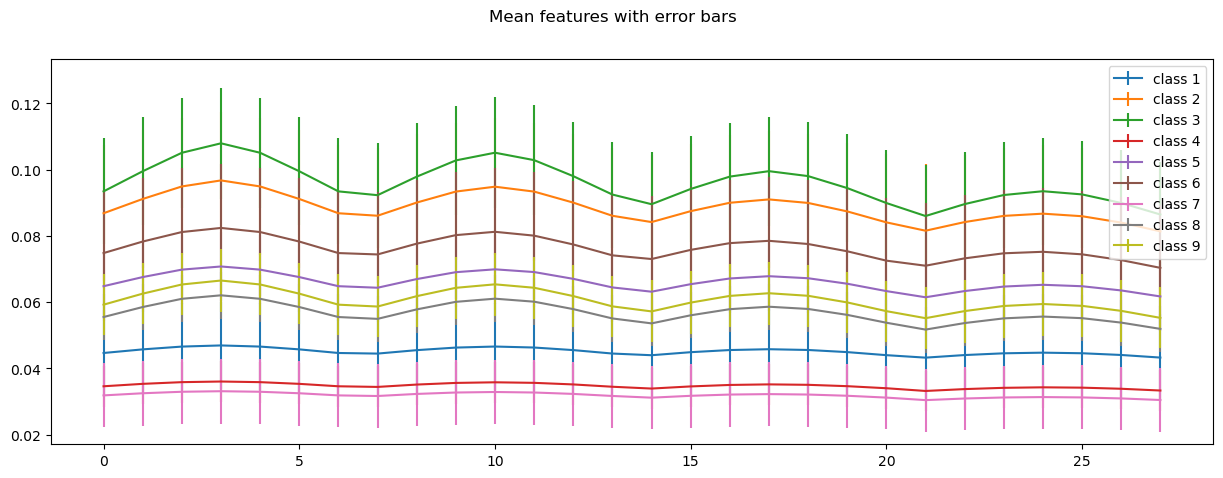

In [43]:
plot_mean_per_class(resultsAutoCov, covTrain, NbMapsTrain, False)
# plot_mean_per_class(resultsAutoCov, covTest, NbMapsTest, False)

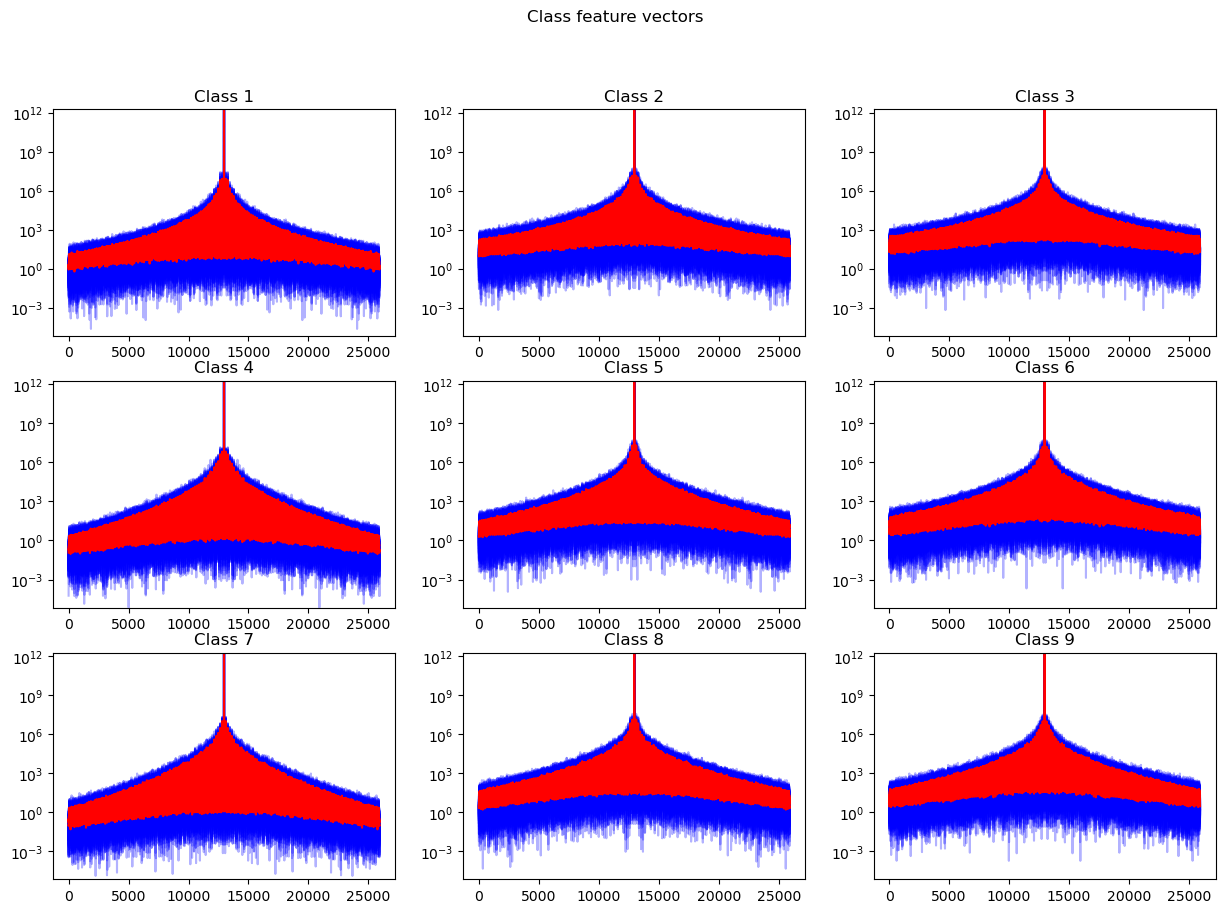

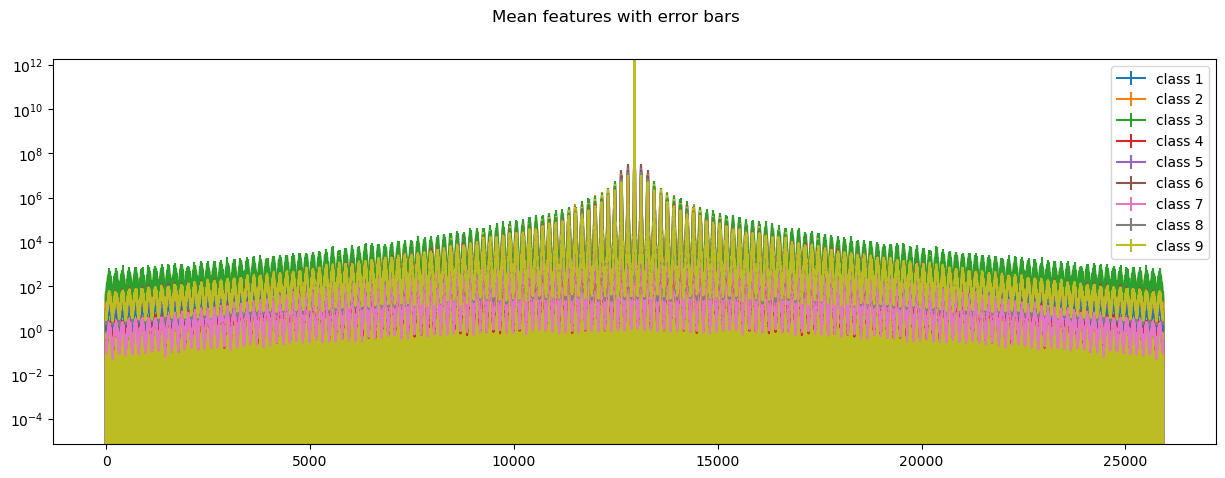

In [38]:
plot_mean_per_class(resultsPS, ps_train, NbMapsTrain, True)
# plot_mean_per_class(resultsPS, ps_test, NbMapsTest, True)

**4.2 TODO :** Quelle invariance de groupe n'a pas été exploitée dans la construction des deux derniers features ?

**4.3 TODO :** En se basant sur les analyses précédentes et une exploration complémentaire, proposer une feature compressée avec une bonne accuracy. 

*Cette question est plus ouverte que les autres. Il n'est pas attendu une feature en particulier, mais des choix d'exploration motivés. La mise en application des concepts étudiés dans le cours, la prise en compte des résultats obtenus précédemment, l'effort de recherche et les illustrations seront valorisés.*

In [30]:
def compute_scattering_features(Imgs: dict, NbClasses: int, NbMaps: int, SizeMaps: int):
    '''This function processes images through a wavelet scattering transform to extract
    scattering coefficients, which are then averaged over orientations to achieve
    rotational invariance. The resulting features are flattened and returned for each image.
    '''
    # Initialize the scattering transform
    J = 4  # Scale of the scattering transform
    L = 8  # Number of orientations
    scattering = Scattering2D(J=J, shape=(SizeMaps, SizeMaps), L=L)

    # Compute scattering coefficients for each image
    scattering_coefficients = {i: [] for i in range(1, NbClasses + 1)}


    for i in range(1, NbClasses + 1):
        for j in range(NbMaps):
            img = Imgs[i][j]
            img = np.array(img, dtype=np.float32)
            img = img / 255.0  # Normalize to [0, 1]

            # Compute scattering coefficients
            Sx = scattering(img)

            # Average over orientations to achieve rotational invariance
            S_rot_inv = np.mean(Sx.reshape(1, J, L, -1), axis=2)

            # Flatten the rotationally invariant scattering coefficients
            S_rot_inv_flat = S_rot_inv.reshape(-1)

            scattering_coefficients[i].append(S_rot_inv_flat)

    return scattering_coefficients

In [ ]:
scattering_coefficients_train = compute_scattering_features(ImgsTrain, NbClasses, NbMapsTrain, SizeMaps)
scattering_coefficients_test = compute_scattering_features(ImgsTest, NbClasses, NbMapsTest, SizeMaps)
resultsSC = classify_by_LDA(scattering_coefficients_train, scattering_coefficients_test)

Train accuracy: 0.8944444444444445
Test accuracy: 0.5851851851851851


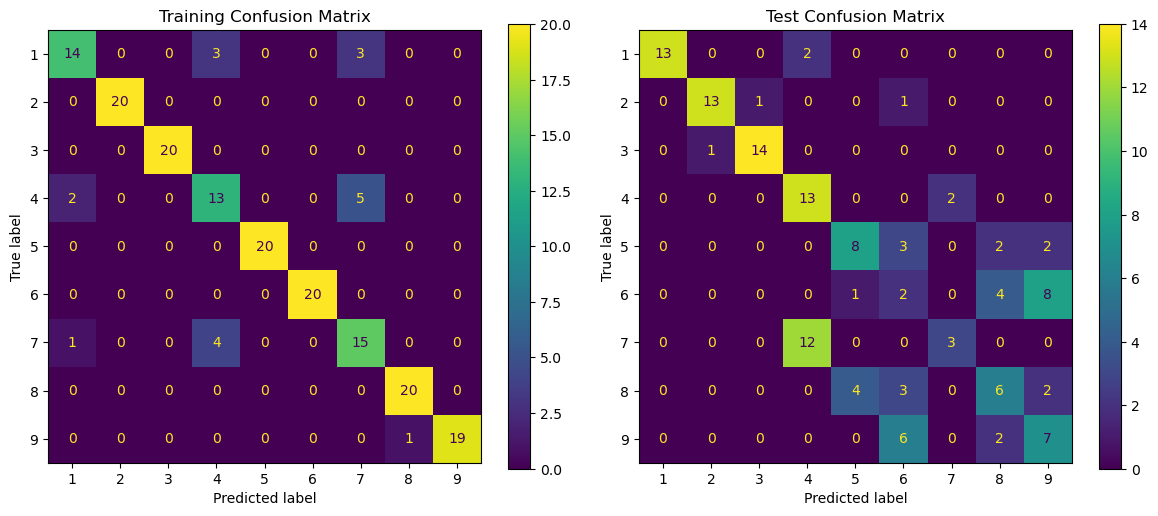

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

display_labels = [i for i in range(1, 10)]  

ConfusionMatrixDisplay(resultsSC["train_cm"], display_labels=display_labels).plot(ax=axs[0])
axs[0].set_title("Training Confusion Matrix")
ConfusionMatrixDisplay(resultsSC["test_cm"], display_labels=display_labels).plot(ax=axs[1])
axs[1].set_title("Test Confusion Matrix")

print("Train accuracy:", resultsSC["train_acc"])
print("Test accuracy:", resultsSC["test_acc"])

plt.tight_layout()
plt.show()

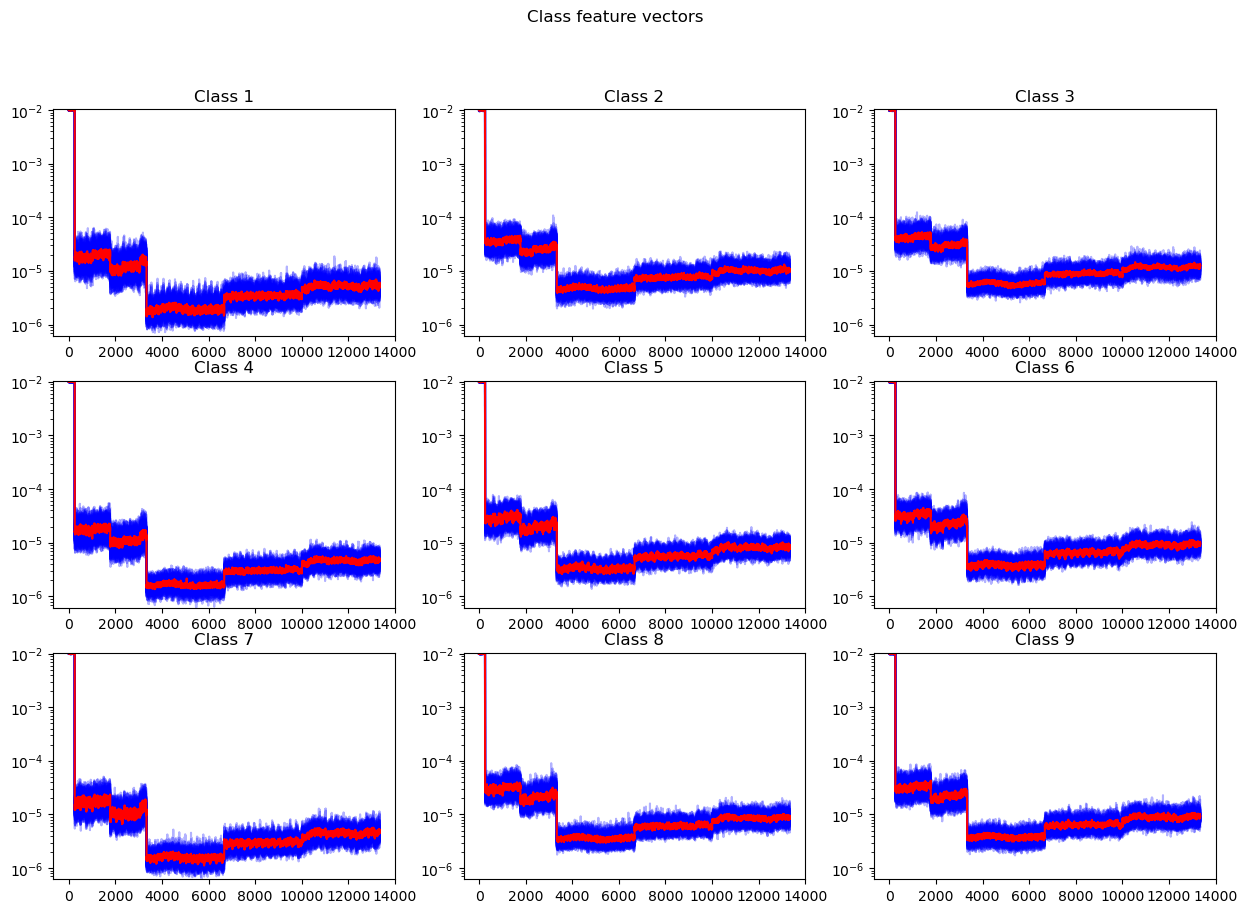

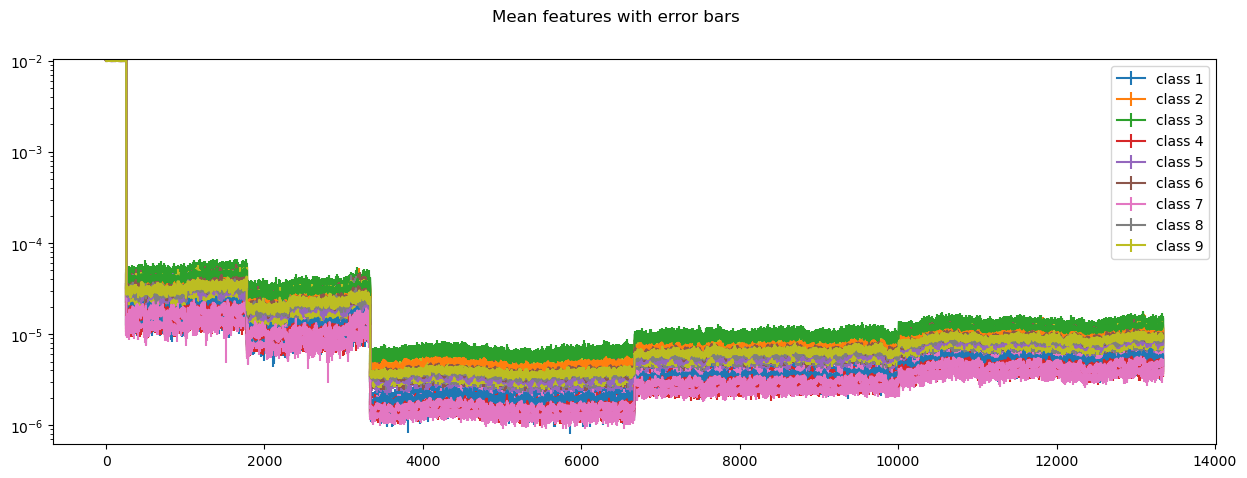

In [ ]:
plot_mean_per_class(resultsSC, scattering_coefficients_train, NbMapsTrain, True)